# DAE with a sign function in the constraint


The studied system is 
$$        \left\{
            \begin{aligned}
                \dot{x}_1(t) =&~ 1+ B_0z(t)\\
                \dot{x}_2(t) =&~ 1 + B_1z(t)\\
                0 =&~ -x_1(t) + x_2(t) + \lambda(t) \\
                \lambda(t) \in&~ \texttt{sign}(x_1(t))
            \end{aligned}
        \right.,$$
with $B_0 = 1$ and $B_1 = 0$ in this particular implentation. Additionally in this Jupyter file we only consider the implementation based on relay function. The simulated model is then:

$$        \left\{
            \begin{aligned}
                \dot{x}_1(t) =&~ 1+ B_0z(t)\\
                \dot{x}_2(t) =&~ 1 + B_1z(t)\\
                0 =&~ -x_1(t) + x_2(t) + \lambda(t) \\
                x_1(t) \in&~ \texttt{Relay}_{[-1,1]}(\lambda(t)) =  -\mathcal{N}_{[-1,1]}(\lambda(t))
            \end{aligned}
        \right.,$$
              

E = 
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
F = 
[[ 0.  0.  1.]
 [ 0.  0.  0.]
 [-1.  1.  0.]]
b = 
[1, 1, 0]


<IPython.core.display.Javascript object>


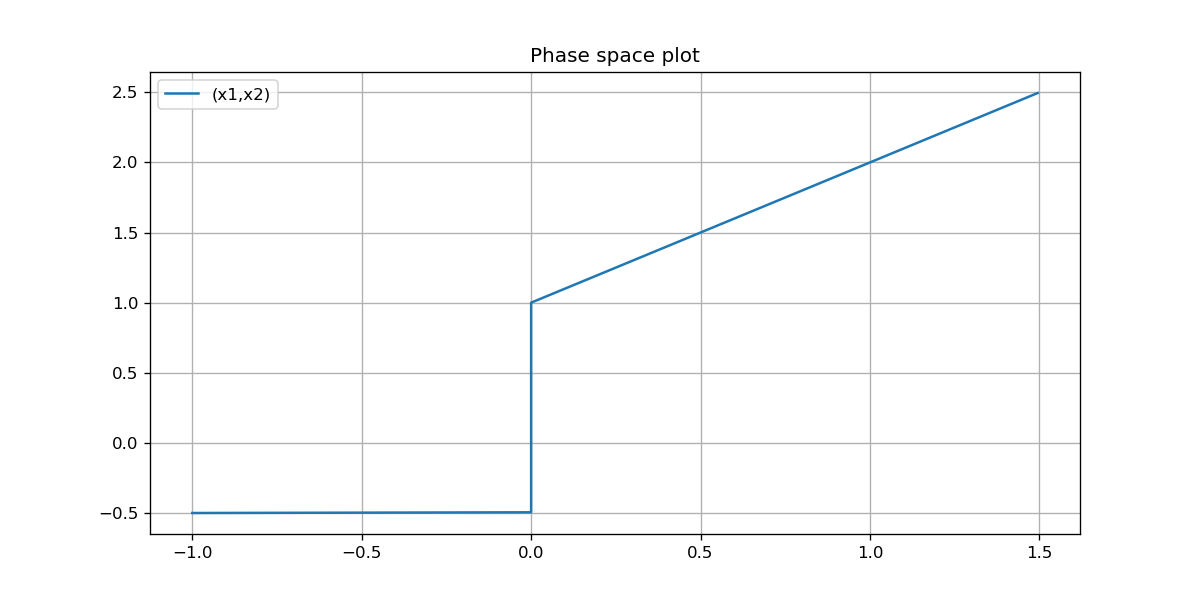

<IPython.core.display.Javascript object>


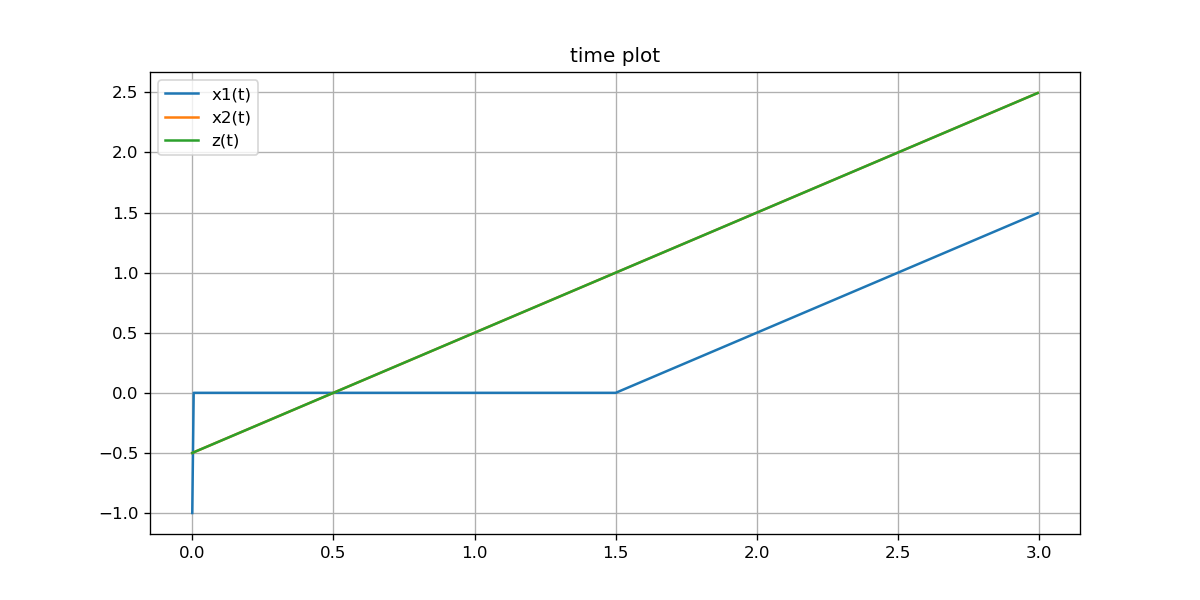

<IPython.core.display.Javascript object>


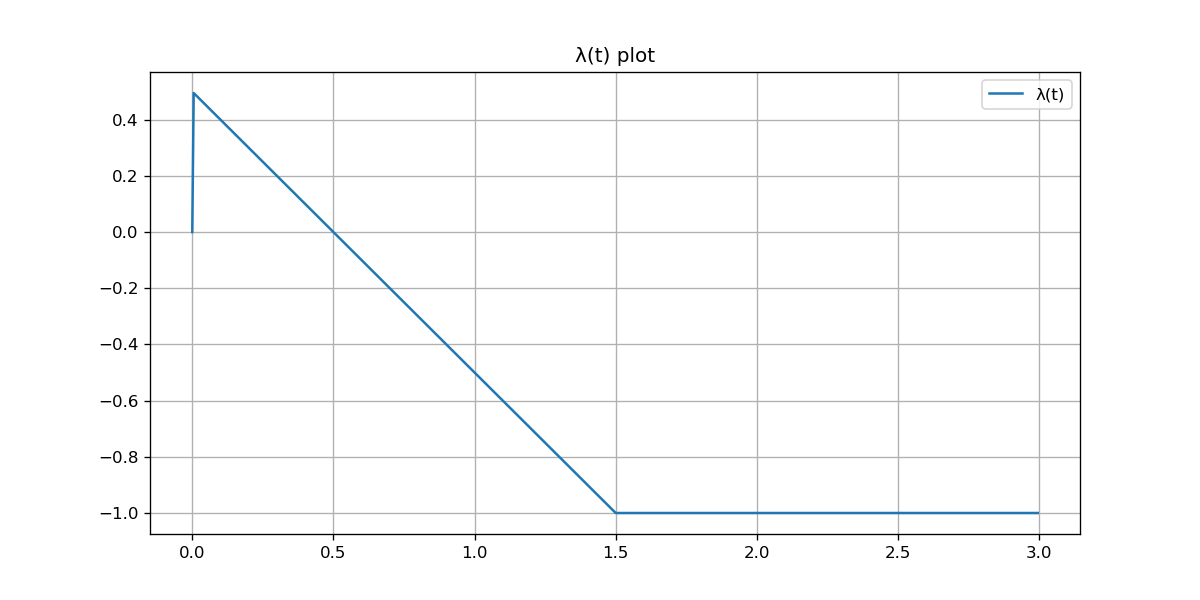

In [2]:
import scipy.linalg as linalg
import numpy as np
import siconos.kernel as sk
from numpy import eye, empty, float64, zeros, transpose, array
from siconos.kernel import FirstOrderLinearTIDS, FirstOrderType2R, FirstOrderLinearTIR, EqualityConditionNSL, RelayNSL,\
                           ComplementarityConditionNSL, NonSmoothDynamicalSystem, Interaction, \
                           EulerMoreauOSI, MoreauJeanOSI, LCP, TimeDiscretisation, TimeStepping 


# Initial conditions
t0       =  0.
T        =  3.
###
# x10      =  0.0
# x20      =  1.0
###
# x10      =  -2.0
# x20      =  -1.5
###
x10      =  -1.0
x20      =  -0.5



x0 = zeros((2,1));
x0[0] = x10;x0[1] = x20;

F = zeros((3,3));
_B = zeros(2); _B[0] = 1.; _B[1] = 0.
F[0:2,2] = _B
C = zeros((1,2)); C[0,0] = -1; C[0,1] = 1;
F[2,0:2] = C

b = [1,1,0]

E = np.eye(3);
E[2,2] = 0

print("E = ")
print(E)
print("F = ")
print(F)
print("b = ")
print(b)

dyn = FirstOrderLinearTIDS([x10,x20,0.0],F,b)
dyn.setMPtr(E) # For Implicit ODE in Siconos

simple_DAE = NonSmoothDynamicalSystem(t0, T)
simple_DAE.insertDynamicalSystem(dyn)

R = zeros((3,1))
R[2,0] = 1.
D = zeros((1,3)); 
D[0,0] = 1;
rel_python = sk.FirstOrderLinearTIR(D, R)
nslaw = sk.RelayNSL(1,-1.,1.)
interaction = Interaction(nslaw, rel_python)
simple_DAE.link(interaction, dyn)

# Discretization and non-smooth problem formulation (Relay)
θ = 1
γ = 1
osi = EulerMoreauOSI(θ,γ)  # One Step time Integrator for First Order Dynamical Systems.

osnspb = sk.Relay()

#### more solver options #####
# import siconos.numerics as sn
# osnspb = sk.Relay(sn.SICONOS_RELAY_ENUM) 
#osnspb = sk.Relay(sn.SICONOS_RELAY_LEMKE) 
#osnspb.setNumericsVerboseMode(True)
#siconos.numerics.setNumericsVerboseMode(3)


# Simulation and time discretisation
time_step =  0.005
td = TimeDiscretisation(t0, time_step)
simu = TimeStepping(simple_DAE, td, osi, osnspb)


##### Simulation run
x = dyn.x()
λ = interaction.lambda_(0) # tracking λ variables form LCP
k = 0

##### Numpy array used to save data at each time step, for post-processing
N = int((T - t0) / simu.timeStep()) + 1
data_plot_4 = zeros((N, 5))

###### Initial state
data_plot_4[k, 0] = t0
data_plot_4[k, 1] = x[0] # x1
data_plot_4[k, 2] = x[1] # x2
data_plot_4[k, 3] = x[2] # σ 
data_plot_4[k, 4] = λ[0]
k += 1

while simu.hasNextEvent():
    simu.computeOneStep() # Build and solve the LCP    
    data_plot_4[k, 0] = simu.nextTime()
    data_plot_4[k, 1] = x[0]
    data_plot_4[k, 2] = x[1]
    data_plot_4[k, 3] = x[2]
    data_plot_4[k, 4] = λ[0]
    k += 1 
    #rel_python.display()
    simu.nextStep() # Save current state and prepare next step

# Plotting
import ipympl
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.title('Phase space plot')
plt.plot(data_plot_4[0:k - 1, 1], data_plot_4[0:k - 1, 2],label='(x1,x2)')
plt.legend()
plt.grid()


plt.figure(figsize=(10,5))
plt.title('time plot')
plt.plot(data_plot_4[0:k - 1, 0], data_plot_4[0:k - 1, 1],label='x1(t)')
plt.plot(data_plot_4[0:k - 1, 0], data_plot_4[0:k - 1, 2],label='x2(t)')
plt.plot(data_plot_4[0:k - 1, 0], data_plot_4[0:k - 1, 2],label='z(t)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.title('λ(t) plot')
plt.plot(data_plot_4[0:k - 1, 0], data_plot_4[0:k - 1, 4],label='λ(t)')
plt.legend()
plt.grid()
plt.show()

osnspb.display()